In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from matplotlib.ticker import MaxNLocator


In [18]:
def vis_k_fold():

    runs = os.listdir("../models")
    k_fold = None
    for run in runs[:]:
        if "K_Fold" in run:
            k_fold = run
    k_fold_runs = os.listdir(os.path.join("../models", k_fold))

    mean_df = None
    concat_df = None
    for i, fold in enumerate(sorted(k_fold_runs)):

        df = pd.read_csv(os.path.join("../models", k_fold, fold, 'results.csv'), index_col=0)
        if mean_df is None:
            mean_df = df.loc['Mean'].rename("Fold 0")
            concat_df = df
        else:
            mean_df = pd.concat((mean_df, df.loc['Mean'].rename(f"Fold {i}")), axis=1)
            concat_df = pd.concat((concat_df, df), axis=0)

    with open("tables/k_fold_table.tex", 'w') as fd:
        mean_df.transpose().to_latex(fd)

    result_dict = {}
    for appliance in set(concat_df.index):
        if 'Mean' not in appliance:
            result_dict[appliance] = concat_df.loc[appliance]['F1'].values

    sns.set(rc={'figure.figsize':(10,5)})
    fig, ax = plt.subplots()
    ax.boxplot(result_dict.values())
    ax.set_xticklabels(result_dict.keys(), rotation = 45)
    ax.set_ylabel('F1 Score')
    plt.tight_layout()
    plt.savefig('figures/f1_k_fold_box.svg', dpi = 300)
    plt.show()

vis_k_fold()

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'NoneType'

ValueError: min() arg is an empty sequence

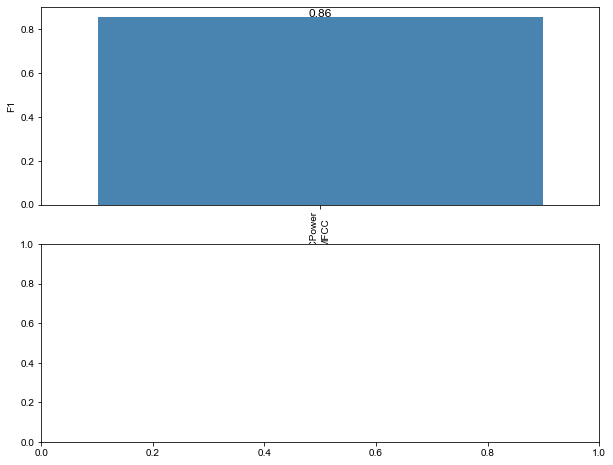

In [19]:
def feature_chaining(model):
    runs = os.listdir("../models/single_models")
    run_dict = {}
    for run in runs[:]:
        if model in run:
            exp_runs = os.listdir(os.path.join("../models/single_models", run))
            features = run.split('[')[1].split(']')[0].replace('_', '\n')[14:]
            f1 = 0
            for exp_run in exp_runs:
                try:
                    df = pd.read_csv(os.path.join("../models/single_models", run, exp_run, 'results.csv'), index_col=0)
                    run_f1 = df['F1'].loc['Mean']
                except FileNotFoundError:
                    run_f1 = 0

                if f1 < run_f1:
                    f1 = run_f1

            run_dict[f1] = features

    run_dict = collections.OrderedDict(sorted(run_dict.items()))

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    #plt.title('Number of events per class')
    idx = int(len(run_dict.values()) / 2)
    if len(run_dict.values()) % 2 == 1:
        idx +=1

    for i in range(0,2):
        df = pd.DataFrame({
            'Features': list(run_dict.values())[idx * i:idx * (i+1)],
            'F1': np.round_(np.asarray(list(run_dict.keys()), dtype=float), 2)[idx * i:idx * (i+1)],
            })

        sns.set(rc={'figure.figsize':(15,5)})
        ax = sns.barplot(ax=axes[i], x='Features', y='F1', data=df, palette="Blues_d")

        for index, row in df.iterrows():
            ax.text(row.name, row.values[1], row.values[1], color='black', ha="center")

        for item in ax.get_xticklabels():
            item.set_rotation(90)

    plt.tight_layout()
    plt.savefig(f'figures/{model}_feature_chaining.svg', dpi=300, bbox_extra_artists=(ax,), bbox_inches='tight')
    plt.show()

feature_chaining('LSTM')

In [24]:
def appliance_table(runs, name_prefix, folder=""):
    df = None
    for i, run in enumerate(runs):
        tmp = pd.read_csv(os.path.join('../models', folder, run, 'results.csv'), index_col=0)
        df = pd.concat([df, tmp[['F1', 'Accuracy']]], axis=1)

    with open(f"tables/{name_prefix}_app_table.tex", 'w') as fd:
        df.round(2).to_latex(fd)

def mean_table(runs, name_prefix, folder=""):
    labels = ['CNN', 'LSTM', 'ResNet', 'DenseNet']
    df = None
    for i, run in enumerate(runs):
        tmp = pd.read_csv(os.path.join('../models', folder, run, 'results.csv'), index_col=0)
        df = pd.concat([df, tmp.loc['Mean'].rename(labels[i])], axis=1)

    with open(f"tables/{name_prefix}_table.tex", 'w') as fd:
        df.transpose().round(2).to_latex(fd)

runs=[
    "CNN1D_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS]_Syn/lr-0.055_wd-0.0_nl-4_ss-19",
    "LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23",
    "RESNET_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_COT]_Syn/lr-0.052_wd-0.001_nl-4_ss-20",
    "DENSE_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS_AOT]_Syn/lr-0.075_wd-0.001_nl-3_ss-12"
]
appliance_table(runs, 'single', 'single_models')
mean_table(runs, 'single', 'single_models')

runs=[
    "Federated_16_CNN1D_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS]_Syn/lr-0.055_wd-0.0_nl-4_ss-19_te-100_le-1_iid",
    "Federated_16_LSTM_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_ACPower_MFCC]_Syn/lr-0.045_wd-0.001_nl-1_ss-23_te-100_le-1_iid",
    "Federated_16_RESNET_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_COT]_Syn/lr-0.052_wd-0.001_nl-4_ss-20_te-100_le-1_iid",
    "Federated_16_DENSE_SGD_CrossEntropyLoss_CLASS_12_[RandomAugment_MFCC_DCS_AOT]_Syn/lr-0.075_wd-0.001_nl-3_ss-12_te-100_le-1_iid"
]
mean_table(runs, 'iid')
mean_table(runs, 'single', '')

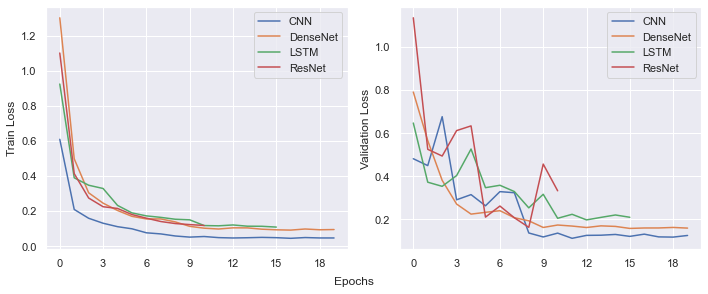

In [21]:
def show_train_val_loss(folder):
    runs = sorted(os.listdir(os.path.join('loss', folder)))

    sns.set(rc={'figure.figsize':(15,5)})
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, run in enumerate(runs):
        df = pd.read_csv(os.path.join('loss', folder, run))
        if 'Train' in run:
            axes[0].plot(df['Value'])
        else:
            axes[1].plot(df['Value'])

    axes[0].set_ylabel('Train Loss')
    axes[1].set_ylabel('Validation Loss')
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.text(0.5, 0, 'Epochs', ha='center', va='center')
    axes[0].legend(['CNN', 'DenseNet', 'LSTM', 'ResNet'])
    axes[1].legend(['CNN', 'DenseNet', 'LSTM', 'ResNet'])
    plt.tight_layout()
    plt.savefig(f'figures/single_loss.svg', dpi=300)
    plt.show()

show_train_val_loss('single_models')

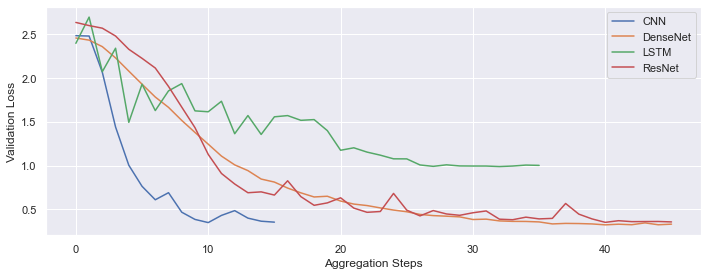

In [23]:
def show_val_loss(folder):
    runs = sorted(os.listdir(os.path.join('loss', folder)))

    sns.set(rc={'figure.figsize':(15,5)})
    fig, axes = plt.subplots(1, 1, figsize=(10, 4))
    for i, run in enumerate(runs):
        df = pd.read_csv(os.path.join('loss', folder, run))
        axes.plot(df['Value'])

    axes.set_ylabel('Validation Loss')
    axes.set_xlabel('Aggregation Steps')
    plt.tight_layout()
    plt.legend(['CNN', 'DenseNet', 'LSTM', 'ResNet'])
    plt.savefig(f'figures/loss.svg', dpi=300)
    plt.show()

show_val_loss('iid_models')